# Universal Sentence Representations
---
This project experiments with different ways to learn universal sentence representations. Four different neural models are implemented to encode sentences. These models are trained on the Stanford Natural Language Inference corpus to classify sentence pairs based on their relation. The learned sentence representations are evaluated using the SentEval framework.
![](architectures.png)

## Import Libraries

In [1]:
import sys
import torch
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
from trainer import Trainer
from models.uni_lstm import UniLSTM
from models.bi_lstm import BiLSTM
from models.bi_lstm_pool import BiLSTMPool
from models.embedding_encoder import EmbeddingEncoder
from utils import report_senteval
from utils import SentenceEncoder

## Global Config

In [3]:
PATH_TO_SENTEVAL = 'SentEval'
PATH_TO_DATA = 'SentEval/data'
pd.set_option("display.precision", 3)

In [4]:
sys.path.insert(0, PATH_TO_SENTEVAL)
import senteval

In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

# 1. SNLI & SentEval Performance
Here, we measure the performance of our trained models on the original task they were trained on: Stanford Natural Language Inference. Then we evaluate the learned sentence representations using the SentEval framework on the following transfer tasks:

|   Code 	| Task Description             	|
|-------:	|------------------------------	|
|     MR 	| Movie Review                 	|
|     CR 	| Product Review               	|
|   SUBJ 	| Subjectivity Status          	|
|   MQPA 	| Opinion Polarity             	|
|    SST 	| Binary Sentiment Analysis    	|
|   TREC 	| Question type Classification 	|
| SICK-E 	| Natural Language Inference   	|
|   MRPC 	| Paraphrase Detection         	|
|  STS14 	| Semantic Textual Similarity  	|

In [6]:
def batcher(params, batch):
    batch = [sent if sent != [] else ['.'] for sent in batch]
    embeddings = []
    for sent in batch:
        sent_tokens = torch.tensor([[params.vocab.stoi[word] for word in sent]])
        x = (sent_tokens, [len(sent_tokens)])
        with torch.no_grad():
            sent_vec = params.encoder(x)
        embeddings.append(sent_vec.detach().numpy())
    embeddings = np.vstack(embeddings)
    return embeddings

In [7]:
params = {'task_path': PATH_TO_DATA, 'usepytorch': False, 'kfold': 5}
params['classifier'] = {'nhid': 0, 'optim': 'adam', 'batch_size': 128, 'tenacity': 2, 'epoch_size': 3}
transfer_tasks = ['MR', 'CR', 'MPQA', 'SUBJ', 'SST2', 'TREC', 'MRPC', 'SICKEntailment', 'STS14']  

## Baseline: Embedding Average
The first model takes the pre-trained GloVe word embeddings for each word in the sentence and simply averages them to come up with the sentence representations. This serves as our baseline model to compare the LSTM models against. Although this bag-of-words approach to sentence representation looks naive, it is quite a strong baseline. 

In [8]:
config = {
    "exp_name": "baseline",
    "epochs": 20,
    "encoder": "EmbeddingEncoder",
    "batch_size": 128,
    "learning_rate": 1e-3,
    "seed": 42,
    "debug": False,
    "device": 'cpu',
    "valid_freq": 1000,
    "save_freq": 2000,
    "test_checkpoint": 'best-model.pt'
}

In [9]:
trainer = Trainer(config) 
print(trainer.test())

INFO:trainer:--------------------------------------------------
INFO:trainer:EXPERIMENT: baseline
INFO:trainer:--------------------------------------------------
INFO:trainer:Setting seed: 42
INFO:trainer:Loading data ...
INFO:trainer:Using device: cpu
INFO:trainer:Loading checkpoint from checkpoints/baseline/best-model.pt


[Test]	Accuracy: 0.777 Total Loss: 1.528


In [11]:
def prepare(params, samples):
    params.vocab = trainer.vocab
    params.encoder = trainer.model.encoder    
    return

In [12]:
se = senteval.engine.SE(params, batcher, prepare)
results = se.eval(transfer_tasks)

In [14]:
report_senteval(results)

,CR,MPQA,MR,MRPC,SICKEntailment,SST2,SUBJ,TREC,macro,micro
metric,79.16,84.67,75.01,70.85,81.0,77.64,90.52,67.64,78.311,79.828
n_samples,3775.00,10606.00,10662.00,4076.00,500.0,872.00,10000.00,5452.00,45943.000,10209.556


We observe that the rather simple looking average embedding model achieves a strong baseline. Most importantly we take note of the accuracy of the model on the SNLI test set. To aggregate the performance of the model on the SentEval framework we take note of the macro and micro measurements on the development set:  
* SNLI Test Accuracy: **77%**
* SentEval Macro: **78%**
* SentEval Micro: **79%**

## Unidirectional LSTM
The unidirectional LSTM model employs a single layer of 2048 hidden units. The last hidden representation of the sequence is considered the hidden representation of the sentence. Whereas using recurrence is sure to result in performance gains over the last baseline, it might still have problems processing longer sentences where the chances of forgetting the initial information is quite high.

In [9]:
config = {
    "exp_name": "uni_lstm",
    "epochs": 20,
    "encoder": "UniLSTM",
    "batch_size": 128,
    "hidden_dim": 2048,
    "num_layers": 1,
    "learning_rate": 1e-3,
    "seed": 42,
    "debug": False,
    "device": 'cpu',
    "valid_freq": 1000,
    "save_freq": 4000,
    "test_checkpoint": 'best-model.pt'
}

In [10]:
uni_trainer = Trainer(config) 
print(uni_trainer.test())

INFO:trainer:--------------------------------------------------
INFO:trainer:EXPERIMENT: uni_lstm
INFO:trainer:--------------------------------------------------
INFO:trainer:Setting seed: 42
INFO:trainer:Loading data ...
INFO:trainer:Using device: cpu
INFO:trainer:Loading checkpoint from checkpoints/uni_lstm/best-model.pt


[Test]	Accuracy: 0.812 Total Loss: 0.517


In [12]:
def prepare(params, samples):
    params.vocab = uni_trainer.vocab
    params.encoder = uni_trainer.model.encoder    
    return

In [13]:
se = senteval.engine.SE(params, batcher, prepare)
results = se.eval(transfer_tasks)

In [16]:
report_senteval(results)

,CR,MPQA,MR,MRPC,SICKEntailment,SST2,SUBJ,TREC,macro,micro
metric,80.56,87.63,77.06,73.55,82.34,80.52,90.16,74.04,80.732,82.092
n_samples,3775.00,10606.00,10662.00,4076.00,500.00,872.00,10000.00,5452.00,45943.000,10209.556


We find that the use of recurrence in the form of a single LSTM layer with 2048 hidden units does indeed result in performance gains. The accuracy on the SNLI test set increases and so does the SentEval metrics. Both the macro and micro accuracy over the development set of the SentEval framework increases from the last baseline:  
* SNLI Test Accuracy: **81%**
* SentEval Macro: **80%**
* SentEval Micro: **82%**

## Bidirectional LSTM
A major limitation of recurrent models is the loss of information over longer sequences. Although LSTMs were developed with smart gating mechanisms to mitigate such problems, it does not entirely go away. Hence, we use bidirectionality to  encode the sentence from both sides. The final hidden representation of the sentence is then extracted for both the directions and then concatenated. This results in each sentence having 4096 features.

In [18]:
config = {
    "exp_name": "bi_lstm",
    "epochs": 20,
    "encoder": "BiLSTM",
    "batch_size": 128,
    "hidden_dim": 2048,
    "num_layers": 1,
    "learning_rate": 1e-3,
    "seed": 42,
    "debug": False,
    "device": 'cpu',
    "valid_freq": 1000,
    "save_freq": 4000,
    "test_checkpoint": 'best-model.pt'
}

In [19]:
bi_trainer = Trainer(config) 
print(bi_trainer.test())

INFO:trainer:--------------------------------------------------
INFO:trainer:EXPERIMENT: bi_lstm
INFO:trainer:--------------------------------------------------
INFO:trainer:Setting seed: 42
INFO:trainer:Loading data ...
INFO:trainer:Using device: cpu
INFO:trainer:Loading checkpoint from checkpoints/bi_lstm/best-model.pt


[Test]	Accuracy: 0.826 Total Loss: 0.473


In [21]:
def prepare(params, samples):
    params.vocab = bi_trainer.vocab
    params.encoder = bi_trainer.model.encoder    
    return

In [22]:
se = senteval.engine.SE(params, batcher, prepare)
results = se.eval(transfer_tasks)

In [14]:
report_senteval(results)

,CR,MPQA,MR,MRPC,SICKEntailment,SST2,SUBJ,TREC,macro,micro
metric,80.88,87.99,76.83,73.85,82.66,80.82,90.75,75.0,81.097,82.427
n_samples,3775.00,10606.00,10662.00,4076.00,500.00,872.00,10000.00,5452.0,45943.000,10209.556


With bidirectionality we get the gains in SNLI test accuracy as we expected. The aggregate macro and micro metrics on the SentEval framework also improve. However, there still exists scope for improvement:  
* SNLI Test Accuracy: **82%**
* SentEval Macro: **81%**
* SentEval Micro: **82%**

## Bidirectional LSTM with Max Pooling
Taking the last hidden activation of the LSTM layers is not always the most optimal thing to do. One of the approaches we can take is by max pooling all the hidden representations across the sequence.

![](bi_lstm_maxpool.png)

In [9]:
config = {
    "exp_name": "bi_lstm_pool",
    "epochs": 20,
    "encoder": "BiLSTMPool",
    "batch_size": 128,
    "hidden_dim": 2048,
    "num_layers": 1,
    "learning_rate": 1e-3,
    "seed": 42,
    "debug": False,
    "device": 'cpu',
    "valid_freq": 1000,
    "save_freq": 4000,
    "test_checkpoint": 'best-model.pt'
}

In [10]:
bimax_trainer = Trainer(config) 
print(bimax_trainer.test())

INFO:trainer:--------------------------------------------------
INFO:trainer:EXPERIMENT: bi_lstm_pool
INFO:trainer:--------------------------------------------------
INFO:trainer:Setting seed: 42
INFO:trainer:Loading data ...
INFO:trainer:Using device: cpu
INFO:trainer:Loading checkpoint from checkpoints/bi_lstm_pool/best-model.pt


[Test]	Accuracy: 0.863 Total Loss: 0.402


In [12]:
def prepare(params, samples):
    params.vocab = bimax_trainer.vocab
    params.encoder = bimax_trainer.model.encoder    
    return

In [35]:
se = senteval.engine.SE(params, batcher, prepare)
results = se.eval(transfer_tasks)

In [41]:
report_senteval(results)

,CR,MPQA,MR,MRPC,SICKEntailment,SST2,SUBJ,TREC,macro,micro
metric,81.16,88.67,77.01,74.85,84.0,81.64,91.52,75.64,81.811,83.011
n_samples,3775.00,10606.00,10662.00,4076.00,500.0,872.00,10000.00,5452.00,45943.000,10209.556


By max pooling the bidirectional LSTM representations we gain impressive performance boost on the test accuracy of the SNLI corpus. However, we do not see the same improvements in the aggregate macro and micro metrics of the SentEval framework:  
* SNLI Test Accuracy: **86%**
* SentEval Macro: **81%**
* SentEval Micro: **83%**

# 2. Analysis & Discussion

We see that the test accuracy rises from 77% to 86% as we go from the baseline model to the max pooling bidirectional lstm. Although the aggregate scores on SentEval also rise proportionally, max pooling does not achieve the same improvements. Here, we investigate the possible reasons.

### Validation Loss for Embedding Average Model
<img src="results/baseline/Loss_Valid.svg" width=500px>

The validation loss of the baseline model converges very early at around 10k steps with a loss of 0.85 before sharply rising.

### Validation Loss for Unidirectional LSTM Model
<img src="results/uni_lstm/Loss_Valid.svg" width=500px>

The validation loss of the unidirectional lstm model does a little bit better and converges around 0.76 at 20k steps to shoot up again.

### Validation Loss for Bidirectional LSTM Model
<img src="results/bi_lstm/Loss_Valid.svg" width=500px>

The validation loss here does a little better the unidirectional model by converging at 0.73 before shooting up sharply.

### Validation Loss for Bidirectional LSTM with Max Pooling 
<img src="results/bi_lstm_pool/Loss_Valid.svg" width=500px>

The validation loss here does not show the trend seen earlier. The Bidirectional lstm with max pooling sharply goes down to around 0.5 but then keeps decreasing but slowly.

This suggests that the Bidirectional LSTM with max pooling has not yet converged and might be able to learn further. It also clearly shows that the model has achieved a lower loss than any other previous models. The authors of the original paper suggest that this might be due to the higher capacity of the model and the use of Adam optimizer. It also leads to the observed phenomenon that it performs really well on the SNLI tasks which it has learned really well. But due to this specialization it cannot show similar improvements in the other SentEval transfer tasks.

We can confirm this behaviour by observing the performance of all the models on the transfer task closest to SNLI, which is SICK-E. Here we see that model does show an improvement over the previous models. This is a strong evidence to support the claim that the bidirectional model with max pooling has indeed overfit to the natural language inference tasks where it performs well but does not generalize that well to other transfer tasks. Perhaps training it for longer would help it to learn more general sentence representations.

# 3. Visualising Representations

Here, we try to visualize the sentence representations of the LSTM models. More specifically we look at the word importance in the sentence representations. This is done by taking the maximum activations in each hidden dimension of every activation in the sequence. The total number of maximums activation dimensions are computed for each word. These sums are the importance score of every word in the sentence.

## Unidirectional LSTM

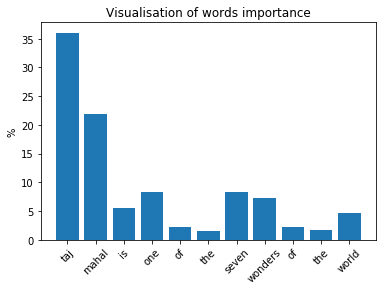

In [16]:
uni_trainer.model.encoder.visualize("taj mahal is one of the seven wonders of the world".split(), uni_trainer.vocab)

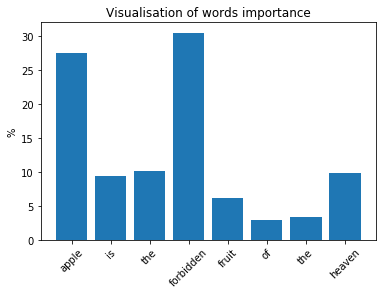

In [17]:
uni_trainer.model.encoder.visualize("apple is the forbidden fruit of the heaven".split(), uni_trainer.vocab)

Here, we see that hte first word has a proportionally higher importance. And for longer sentences like the first one the importance score decreases towards the end. This might be due to the compensatory mechanism of the LSTM layer to prevent forgetting of the earlier activations.

## Bidirectional LSTM

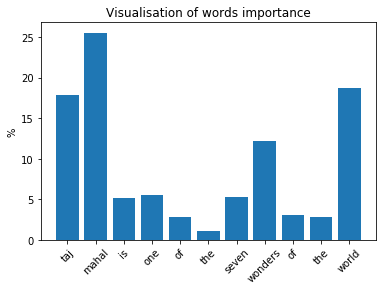

In [25]:
bi_trainer.model.encoder.visualize("taj mahal is one of the seven wonders of the world".split(), bi_trainer.vocab)

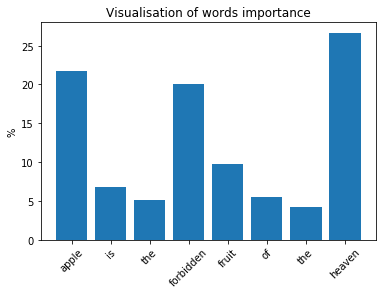

In [26]:
bi_trainer.model.encoder.visualize("apple is the forbidden fruit of the heaven".split(), bi_trainer.vocab)

Here we find that the bidirectionality does help. The first words are not always highly important. Infact we see it rightly captures important words from both sides of the sentence.

## Bidirectional LSTM with Max Pooling

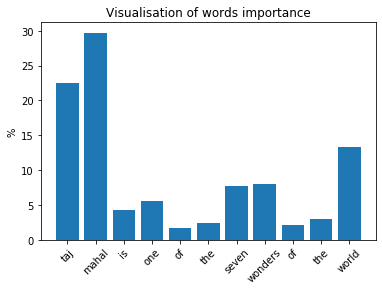

In [13]:
bimax_trainer.model.encoder.visualize("taj mahal is one of the seven wonders of the world".split(), bimax_trainer.vocab)

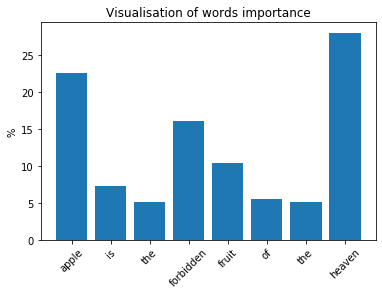

In [14]:
bimax_trainer.model.encoder.visualize("apple is the forbidden fruit of the heaven".split(), bimax_trainer.vocab)

Here we find a similar result as the bidirectional LSTM. In fact this method of finding the important words does not really differentiate between the pooling approach applied to this model. Hence similar results were expected.

## Sentence Similarities

Now we demonstrate a sample of the task the model was trained for i.e. finding relations between pairs of sentences.

In [17]:
Bi_LSTM_max = SentenceEncoder(bimax_trainer.model.encoder, bimax_trainer.vocab)

In [33]:
Bi_LSTM_max.cosine_similarity("we went swimming in the sun", "it was a sunny day")

0.21210186

In [34]:
Bi_LSTM_max.cosine_similarity("we went swimming in the sun", "it was a rainy day")

0.090802304

# Conclusion

In conclusion, we find that a bidirectional LSTM with max pooling does learn the best representations for the SNLI corpus. However, due to the higher capacity of the model it specializes on the language inference task and does not generalize as well to the SentEval transfer tasks. One possible way to mitigate this could be to train the model for longer to look for a better loss topology.